## Importing libs

In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt

om0 = 1

## 2-body problem
We will work at constant a.

In [2]:
from motion_solver import mom_update, pos_update
from time_handler import density_update, affiche
from poisson_solver import psolve
def step2b(grid, pos, mom, l, m, a, da):
    _ = mom_update(-grid, pos, mom, a, da, l)
    _ = pos_update(pos, mom, a, da, l)
    _ = density_update(grid, pos, l, m)
    _ = psolve(grid, a)
    return 0

def simulator2b(l, m, a, da, pos_init, mom_init, show=True):
    grid = np.zeros((l,l,l))
    pos, mom = pos_init, mom_init

    line = affiche(pos, 0, l, show, True)

    l_pos = [np.copy(pos_init)[0]]
    for current_a in a[1:]:
        step2b(grid, pos, mom, l, m, current_a, da)
        if show:
            print('a :{:.3f} / {:.3f}--- p : {} --- dx : {}'.format(current_a, a[-1], mom[0], pos[0]- x_pre))
        l_pos.append(np.copy(pos[0]))
        affiche(pos, line, l, show, False)
        plt.pause(0.01)
    affiche(pos, line, l, show, False)
    plt.show()
    return l_pos

KeyboardInterrupt: 

[4. 4.]


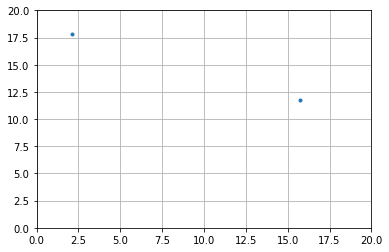

In [6]:
N = 2
L = 20
m = 1
a = np.ones(50) * 0.1
da = 0.001

pos_init = np.random.random((N, 3)) * L
mom_init = (np.random.random((N, 3)) - 0.5) * 1

lpos = simulator2b(L, m, a, da, pos_init, mom_init, True)

## Testing the Poisson solver and the given acceleration

<Figure size 288x288 with 0 Axes>

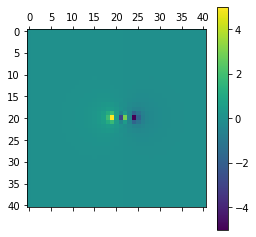

In [3]:
import poisson_solver as ps
mid = 20
n = 2 * mid + 1
r = 3
delta = np.zeros((n,n,n))
#for a in range(-r, r+1):
#    for b in range(-r, r+1):
#        for c in range(-r, r+1):
#            if (a**2 + b**2 + c**2) < r**2:
#                delta[mid+a, mid+b, mid+c] = 1
delta[mid, mid, mid] = 1
delta[mid, mid, mid+3] = 1
delta = fft.fftn(delta)
L = np.shape(delta)[0]
kx, ky, kz = fft.fftfreq(L), fft.fftfreq(L), fft.fftfreq(L)
delta *= ps.G(kx, ky, kz, 1, 1)
delta = fft.ifftn(delta).real


def g(i,j,k, c, tab):
    if c==0:
        return (tab[(i+1)%n,j,k] - tab[(i-1)%n,j,k])/2
    elif c==1:
        return (tab[i,(j+1)%n,k] - tab[i,(j-1)%n,k])/2
    return (tab[i,j,(k+1)%n] - tab[i,j,(k-1)%n])/2

delta = - delta
observer = mid
acc = np.zeros((n,n))
for j in range(n):
    for k in range(n):
        acc[j, k] = g(observer, j, k, 2, delta)


plt.figure(figsize=plt.figaspect(1))
#plt.matshow(delta[mid])
plt.matshow(acc)
plt.colorbar()
plt.show()

$\nabla^2 \phi = 4 \pi \delta \implies \phi = - 1 / r$

In [34]:
import poisson_solver as ps
om0, a = 1, 1
mid = 20
n = 2 * mid + 1
m = 1

r = 3
grid = np.zeros((n,n,n))
grid[mid, mid, mid] = m
for a in range(-r, r+1):
    for b in range(-r, r+1):
        for c in range(-r, r+1):
            if (a**2 + b**2 + c**2) <= r**2:
                grid[mid+a, mid+b, mid+c] = m
m = np.sum(grid)

grid = fft.fftn(grid)
kx, ky, kz = 2 * np.pi * fft.fftfreq(n), 2 * np.pi * fft.fftfreq(n), 2 * np.pi * fft.fftfreq(n)# 2 * np.pi * fft.fftfreq(n, d=1), 2*np.pi * fft.fftfreq(n, d=1), 2*np.pi * fft.fftfreq(n, d=1)
grid *= ps.G(kx, ky, kz, a, om0)
grid = fft.ifftn(grid).real

grid_th = np.zeros((n, n, n))
G_th = 3 * om0 * m/ (8 * np.pi * a)

corr_order = 2
for x in range(-mid, mid+1):
    for y in range(-mid, mid+1):
        for z in range(-mid, mid+1):
            if x != 0 or y != 0 or z != 0:
                for a in [x + k * n for k in range(-corr_order, corr_order+1)]:
                    for b in [y + k * n for k in range(-corr_order, corr_order+1)]:
                        for c in [z + k * n for k in range(-corr_order, corr_order+1)]:
                            grid_th[x+mid, y+mid, z+mid] += - G_th / np.sqrt(a**2 + b**2 + c**2)


grid_th -= np.mean(grid_th)

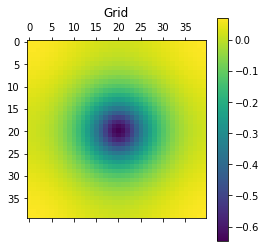

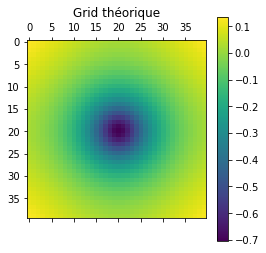

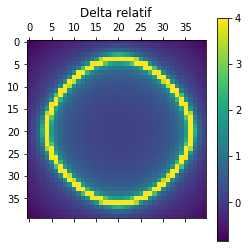

In [35]:
observer = mid + 5
lim = mid

plt.matshow(grid[observer, mid-lim:mid+lim, mid-lim:mid+lim])
plt.title("Grid")
plt.colorbar()
plt.show()
plt.matshow(grid_th[observer, mid-lim:mid+lim, mid-lim:mid+lim])    
plt.title("Grid théorique")
plt.colorbar()
plt.show()
delta_rel = (grid- grid_th) / np.abs(grid)
for x in range(n):
    for y in range(n):
        for z in range(n):
            delta_rel[x, y, z] = min(delta_rel[x, y, z], 4)
# delta_rel = grid/grid_th
plt.matshow(delta_rel[observer, mid-lim:mid+lim, mid-lim:mid+lim])
plt.title("Delta relatif")
plt.colorbar()
plt.show()

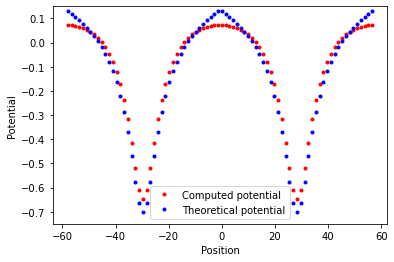

In [36]:
plt.plot(np.sqrt(2) * np.arange(-mid - n//2 -1, mid+n//2+1), 2 * [grid[observer, i, i] for i in range(n)], 'r.', label='Computed potential')
plt.plot(np.sqrt(2) * np.arange(-mid - n//2 -1, mid+n//2+1), 2 * [grid_th[observer, i, i] for i in range(n)], 'b.', label='Theoretical potential')
plt.legend()
plt.ylim(-0.75, 0.15)
plt.xlabel('Position')
plt.ylabel('Potential')
plt.show()

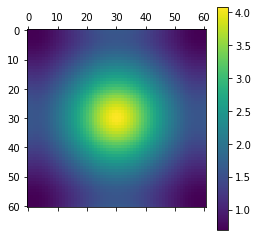

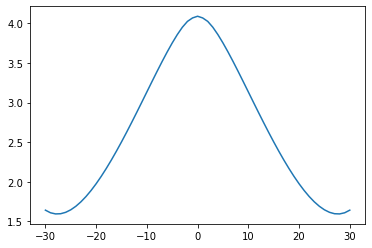

In [8]:
grid -= grid[0, 0, 0]
fit = np.zeros((n, n, n))
for x in range(-mid, mid+1):
    for y in range(-mid, mid+1):
        for z in range(-mid, mid+1):
            if x != 0 or y != 0 or z != 0:
                fit[x+mid, y+mid, z+mid] = - np.sqrt(x**2 + y**2 + z**2) * (grid[x+mid, y+mid, z+mid])
plt.matshow(fit[observer])
plt.colorbar()
plt.show()
plt.plot(np.arange(-mid, mid+1), fit[observer, mid])
plt.show()  

In [15]:
print(fft.fftfreq(10))
print(fft.fftfreq(10, d=1))

[ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.1]
[ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.1]


In [ ]:
import poisson_solver as ps
om0, a = 1, 1
mid = 30
n = 2 * mid + 1
m = 1

r = 3
grid1d = np.zeros(n)
grid1d[mid, mid, mid] = m
for a in range(-r, r+1):
    grid1d[mid+a, mid+b, mid+c] = m
m = np.sum(grid)

grid = fft.fftn(grid)
kx, ky, kz = 2 * np.pi * fft.fftfreq(n), 2 * np.pi * fft.fftfreq(n), 2 * np.pi * fft.fftfreq(n)# 2 * np.pi * fft.fftfreq(n, d=1), 2*np.pi * fft.fftfreq(n, d=1), 2*np.pi * fft.fftfreq(n, d=1)
grid *= ps.G(kx, ky, kz, a, om0)
grid = fft.ifftn(grid).real

grid_th = np.zeros((n, n, n))
G_th = 3 * om0 * m/ (8 * np.pi * a)
for x in range(-mid, mid+1):
    for y in range(-mid, mid+1):
        for z in range(-mid, mid+1):
            if x != 0 or y != 0 or z != 0:
                for a in [x-n, x, x+n]:
                    for b in [y-n, y, y+n]:
                        for c in [z-n, z, z+n]:
                            grid_th[x+mid, y+mid, z+mid] += - G_th / np.sqrt(a**2 + b**2 + c**2)


grid_th -= np.mean(grid_th)

<Figure size 288x288 with 0 Axes>

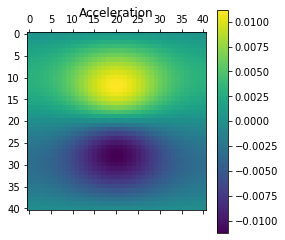

<Figure size 288x288 with 0 Axes>

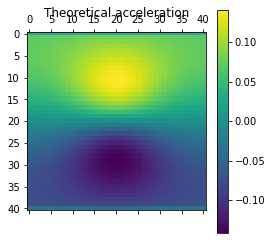

<Figure size 288x288 with 0 Axes>

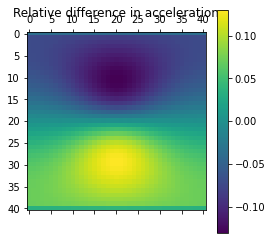

In [54]:
grid_th *= 10
def g(i,j,k, c, tab):
    if c==0:
        return (tab[(i+1)%n,j,k] - tab[(i-1)%n,j,k])/2
    elif c==1:
        return (tab[i,(j+1)%n,k] - tab[i,(j-1)%n,k])/2
    return (tab[i,j,(k+1)%n] - tab[i,j,(k-1)%n])/2

acc = np.zeros((n,n))
acc_th = np.zeros((n, n))
axis = 1
for j in range(n):
    for k in range(n):
        acc[j, k] = - g(observer, j, k, axis, grid)
        acc_th[j, k] = - g(observer, j, k, axis, grid_th)

plt.figure(figsize=plt.figaspect(1))
plt.matshow(acc)
plt.title("Acceleration")
plt.colorbar()
plt.show()

plt.figure(figsize=plt.figaspect(1))
plt.matshow(acc_th)
plt.title("Theoretical acceleration")
plt.colorbar()
plt.show()

acc_diff_rel = acc - acc_th
plt.figure(figsize=plt.figaspect(1))
plt.matshow(acc_diff_rel)
plt.title("Relative difference in acceleration")
plt.colorbar()
plt.show()

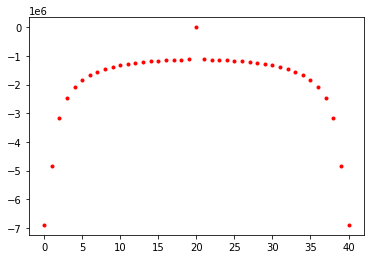

In [30]:
plt.plot(acc_diff_rel[:, mid], 'r.')

## Testing the density update function

In [3]:
def test_du(grid_dens, pos, l, m, delta=True):
    for i in range(l):
        for j in range(l):
            for k in range(l):
                grid_dens[i,j,k] = 0
    for x in pos:
        i, j, k = np.floor(x)
        i, j, k = int(i), int(j), int(k)
        d = x - np.array([i, j, k])
        t = 1 - d
        grid_dens[i, j, k]             += m * t[0] * t[1] * t[2]
        grid_dens[(i+1)%l, j, k]       += m * d[0] * t[1] * t[2]
        grid_dens[i, (j+1)%l, k]       += m * t[0] * d[1] * t[2]
        grid_dens[i, j, (k+1)%l]       += m * t[0] * t[1] * d[2]
        grid_dens[(i+1)%l, (j+1)%l, k] += m * d[0] * d[1] * t[2]
        grid_dens[(i+1)%l, j, (k+1)%l] += m * d[0] * t[1] * d[2]
        grid_dens[i, (j+1)%l, (k+1)%l] += m * t[0] * d[1] * d[2]
        grid_dens[(i+1)%l, (j+1)%l, (k+1)%l] += m * d[0] * d[1] * d[2]
    if delta: # if we want to work with delta tilde instead of rho
        grid_dens -= np.ones(np.shape(grid_dens))
    return grid_dens

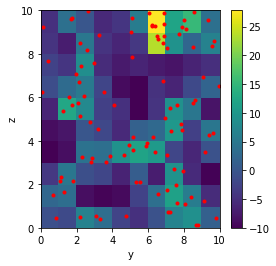

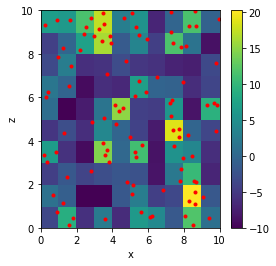

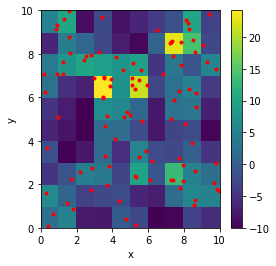

In [4]:
L = 10
N = 100
m = 10
grid = np.zeros((L,L,L))
pos = np.random.random((N,3)) * L
test_du(grid, pos, L, m)
# FOR X
gridX = np.zeros((L,L))
for x in range(L):
    gridX += grid[x,:,:]
plt.figure(figsize=plt.figaspect(1))
plt.pcolor(np.transpose(gridX))
plt.colorbar()
plt.plot((pos[:,1]+.5)%L, (pos[:,2]+.5)%L, 'r.')
plt.xlabel('y')
plt.ylabel('z')
plt.show()

# FOR Y
gridY = np.zeros((L,L))
for y in range(L):
    gridY += grid[:,y,:]
plt.figure(figsize=plt.figaspect(1))
plt.pcolor(np.transpose(gridY))
plt.colorbar()
plt.plot((pos[:,0]+.5)%L, (pos[:,2]+.5)%L, 'r.')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

# FOR Z
gridZ = np.zeros((L,L))
for z in range(L):
    gridZ += grid[:,:,z]
plt.figure(figsize=plt.figaspect(1))
plt.pcolor(np.transpose(gridZ))
plt.colorbar()
plt.plot((pos[:,0]+.5)%L, (pos[:,1]+.5)%L, 'r.')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Plane wave test (from pm.pdf)

In [5]:
Lbox = 100
Np = 10


def Dplus(a):
    return a

def Dpluspt(a):
    return 1

def x(i, a, A=Lbox/2, N=Np, L=Lbox):
    qi = i * L / N
    return qi * Dplus(a) *  A * np.sin(2*np.pi* qi / L)

def p(i, a, da, A=Lbox/2, N=Np, L=Lbox):
    return a**2 * Dpluspt(a - da/2) * A * np.sin(2*np.pi * i / N)

def pw_simulator(l, m, a, pos_init, mom_init):
    grid = np.zeros((l,l,l))
    pos, mom = pos_init, mom_init

    line = affiche(pos, 0, l, True, True)

    x_pre = np.copy(pos_init[0])
    l_pos = [np.copy(pos_init)[0]]
    pre_a = a[0]
    for current_a in a[1:]:
        da = current_a - pre_a
        pre_a = current_a
        step(grid, pos, mom, l, m, current_a, da)
        print('a :{:.3f} / {:.3f}--- p : {} --- dx : {}'.format(current_a, a[-1], mom[0], pos[0]- x_pre))
        x_pre = np.copy(pos[0])
        l_pos.append(np.copy(pos[0]))
        affiche(pos, line, l, True, False)
        plt.pause(0.01)
    affiche(pos, line, l, True, False)
    plt.show()
    return l_pos

In [6]:
# CDM universe ; Om0 = 1
Lbox =  100
Np = 100
a_ini = 0.1
def dplus(a):
    return a
wave_amp = 10


q_ini = np.arange(Np) * Lbox/Np
x_ini = q_ini + dplus(a_ini) * wave_amp * np.sin(2 * np.pi * q_ini / Lbox)
p_ini = a_ini * wave_amp * np.sin(2 * np.pi * q_ini / Lbox) 

## Verifying one particle drift

<function matplotlib.pyplot.show(*args, **kw)>

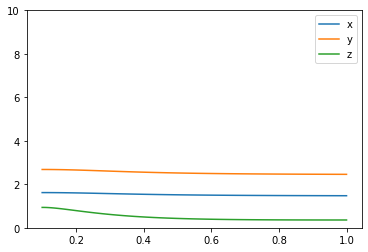

In [8]:
# -*- coding: utf-8 -*-
import numpy as np
from numpy.random import random

import matplotlib.pyplot as plt

from time_handler import simulator

N = 1
L = 10
m = 10

t = np.logspace(-2, 0, 50)
a = np.sqrt(t)

pos_init = random((N, 3)) * L
mom_init = np.zeros((N,3))

l_pos = simulator(L, m, a, pos_init, mom_init, show=False)

x, y, z = [], [], []
for position in l_pos:
    x.append(position[0])
    y.append(position[1])
    z.append(position[2])
## TESTING
plt.plot(a, x, label='x')
plt.plot(a, y, label='y')
plt.plot(a, z, label='z')
plt.ylim(0, L)
plt.legend()
plt.show()

In [ ]:
plt.plot(a, x, label='x')
plt.plot(a, y, label='y')
plt.plot(a, z, label='z')
plt.legend()
plt.show()

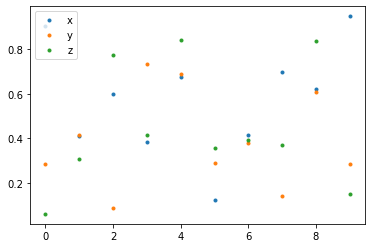

In [24]:
test_nb = 10
x_results, y_results, z_results = np.zeros(test_nb), np.zeros(test_nb), np.zeros(test_nb)

for i in range(test_nb):
    pos_init = random((N, 3)) * L
    l_pos = simulator(L, m, a, pos_init, mom_init, show=False)
    x_results[i] = l_pos[-1][0]
    y_results[i] = l_pos[-1][1]
    z_results[i] = l_pos[-1][2]
plt.plot(x_results-np.floor(x_results), '.', label='x')
plt.plot(y_results-np.floor(y_results), '.', label='y')
plt.plot(z_results-np.floor(z_results), '.', label='z')
plt.legend()
plt.show()

## Solving bugs in motion_solver

In [7]:
from motion_solver import f

N, l = 10, 10
grid = np.random.random((l, l, l))
pos = np.random.random((N, 3))
mom = np.random.random((N, 3))
a = 1
da = 0.01

def g(i,j,k, c, tab=grid):
    if c==0:
        return (tab[(i+1)%l,j,k] - tab[(i-1)%l,j,k])/2
    elif c==1:
        return (tab[i,(j+1)%l,k] - tab[i,(j-1)%l,k])/2
    return (tab[i,j,(k+1)%l] - tab[i,j,(k-1)%l])/2
accs = np.zeros(mom.shape)
for n in range(len(accs)):
    position = pos[n]
    parentcell = np.floor(position)
    i, j, k = parentcell
    i, j, k = int(i), int(j), int(k)
    t = position - parentcell
    d = 1 - t
    for c in range(3):
        accs[n, c] += (g(i,j,k,c)             * t[0]*t[1]*t[2] +
                    g((i+1)%l,j,k,c)       * d[0]*t[1]*t[2] +
                    g(i,(j+1)%l,k,c)       * t[0]*d[1]*t[2] +
                    g((i+1)%l,(j+1)%l,k,c) * d[0]*d[1]*t[2] +
                    g(i,j,(k+1)%l,c)       * t[0]*t[1]*d[2] +
                    g((i+1)%l,j,(k+1)%l,c) * d[0]*t[1]*d[2] +
                    g(i,(j+1)%l,(k+1)%l,c) * t[0]*d[1]*d[2] +
                    g((i+1)%l,(j+1)%l,(k+1)%l,c) * d[0]*d[1]*d[2] )
mom = accs* f(a) * da
accs

array([[-0.13357396, -0.05557708, -0.00180631],
       [-0.06751535, -0.04965972,  0.11819014],
       [-0.14913091, -0.10694163, -0.02670923],
       [-0.14006065, -0.10706922, -0.01216294],
       [-0.17466447, -0.16917471, -0.0256757 ],
       [-0.19385959, -0.07545829,  0.00424619],
       [-0.16375173, -0.15156289, -0.02330182],
       [-0.1803473 , -0.18378542, -0.0940823 ],
       [-0.15240383, -0.0446442 ,  0.03642678],
       [-0.12700493, -0.06410198,  0.02704936]])

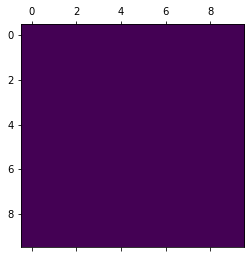

In [13]:
from poisson_solver import psolve
l = 10
grid =np.random.random((l, l, l))
a = 1
temp = np.copy(grid)
psolve(grid, a, om=1)
plt.matshow((grid-temp)[0])